# 前置作業

In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define Project Folder
FOLDERNAME = 'Colab\ Notebooks/Group_A_Project'

%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Group_A_Project


In [ ]:
%%bash
pip install tqdm -q
pip3 install transformers datasets torch -q
pip install sentence-transformers -q
pip install wordcloud -q
pip install matplotlib -q
pip install gradio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.cuda.amp import autocast, GradScaler
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, pipeline
# from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from collections import defaultdict
from imblearn.over_sampling import BorderlineSMOTE
from wordcloud import WordCloud

In [ ]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Seed for same output
torch.manual_seed(42)  # the random numbers generated (e.g., for initializing weights) are the same each time the code is run
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 資料前處理

In [ ]:
# Reading in our file
raw_data = pd.read_csv('Amazon_Unlocked_Mobile.csv')

In [ ]:
# Clean the NAN data in reviews and brand name
raw_data = raw_data.dropna(subset=['Reviews', 'Brand Name'])
raw_data = raw_data.reset_index(drop=True)
print(len(raw_data))
print(raw_data['Reviews'].isnull().sum())
print(raw_data['Brand Name'].isnull().sum())

348616
0
0


In [ ]:
import re
# Get data & labels
reviews = raw_data['Reviews']
# print(reviews)
reviews = reviews.astype(str)
labels = raw_data['Rating']
labels.replace({1:0, 2:0, 3:1, 4:2, 5:2}, inplace=True)
brands = list(zip(raw_data['Brand Name'], raw_data['Reviews']))
df_brands = pd.DataFrame(brands, columns=['Brand Name', 'Reviews'])
print(df_brands)

       Brand Name                                            Reviews
0         Samsung  I feel so LUCKY to have found this used (phone...
1         Samsung  nice phone, nice up grade from my pantach revu...
2         Samsung                                       Very pleased
3         Samsung  It works good but it goes slow sometimes but i...
4         Samsung  Great phone to replace my lost phone. The only...
...           ...                                                ...
348611    Samsung                     another great deal great price
348612    Samsung                                                 Ok
348613    Samsung        Passes every drop test onto porcelain tile!
348614    Samsung  I returned it because it did not meet my needs...
348615    Samsung  Only downside is that apparently Verizon no lo...

[348616 rows x 2 columns]


In [ ]:
print(labels.value_counts())

Rating
2    239536
0     81775
1     27305
Name: count, dtype: int64


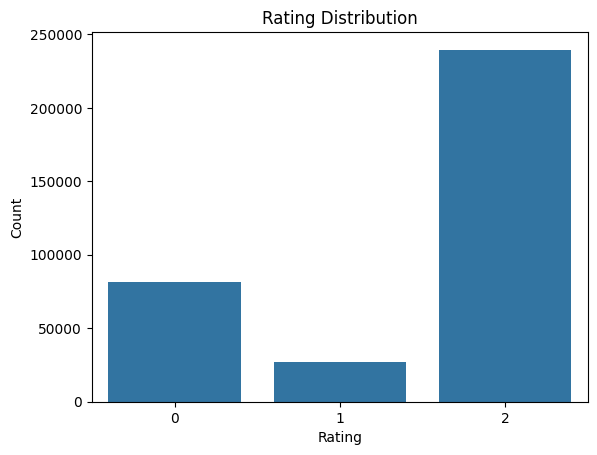

In [ ]:
sns.countplot(x='Rating', data=raw_data)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# 關鍵字提取


提取完記得還原大小然後 combine 完再丟進去訓練

先嘗試 tf-idf

再嘗試 textrank(要算比較久)

In [ ]:
# Limit to the first 1000 reviews
# reviews = reviews[:1000]  # Slice the first 1000 reviews

In [ ]:
# Create a DataFrame with only the reviews
df_reviews = pd.DataFrame(reviews, columns=['Reviews'])

# Example output
print(df_reviews)

                                                  Reviews
0       I feel so LUCKY to have found this used (phone...
1       nice phone, nice up grade from my pantach revu...
2                                            Very pleased
3       It works good but it goes slow sometimes but i...
4       Great phone to replace my lost phone. The only...
...                                                   ...
348611                     another great deal great price
348612                                                 Ok
348613        Passes every drop test onto porcelain tile!
348614  I returned it because it did not meet my needs...
348615  Only downside is that apparently Verizon no lo...

[348616 rows x 1 columns]


#rake

In [ ]:
# %%bash
# pip install rake-nltk -q

In [ ]:
# from rake_nltk import Rake

In [ ]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

# # Initialize RAKE with English stopwords
# rake = Rake()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# def extract_top_keywords_rake(review):
#     rake.extract_keywords_from_text(review)
#     # Get the ranked phrases and scores
#     ranked_phrases_with_scores = rake.get_ranked_phrases_with_scores()
#     # Return the top 5 keywords (or phrases)
#     top_keywords = [phrase for score, phrase in ranked_phrases_with_scores[:5]]
#     return top_keywords

In [ ]:
# # Enable the progress bar
# tqdm.pandas()

# # Apply RAKE keyword extraction to the reviews
# df_reviews['Top Keywords'] = df_reviews['Reviews'].progress_apply(extract_top_keywords_rake)

# # Example output
# print(df_reviews[['Reviews', 'Top Keywords']].head())
# print(df_reviews['Top Keywords'][9])

100%|██████████| 348616/348616 [01:06<00:00, 5263.97it/s]

                                             Reviews  \
0  I feel so LUCKY to have found this used (phone...   
1  nice phone, nice up grade from my pantach revu...   
2                                       Very pleased   
3  It works good but it goes slow sometimes but i...   
4  Great phone to replace my lost phone. The only...   

                                        Top Keywords  
0  [finally fell apart, said used phone, used har...  
1  [great phone samsung, android phone, social me...  
2                                          [pleased]  
3  [goes slow sometimes, works good, good phone, ...  
4   [still go, lost phone, great phone, phone, work]  
['top button several times', 'screen goes black', 'battery life', 'screen', 'touch']


#TF-IDF

In [ ]:
import nltk

# Download the 'stopwords' dataset
nltk.download('stopwords')

# Download the tokenizer resources for POS tagging
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

# Ensure you have downloaded nltk resources (run once)
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

# Sample DataFrame with reviews (replace with your actual data)
# df_reviews = pd.DataFrame({'Reviews': [...]})

# Define your custom stop words
nltk_stop_words = set(stopwords.words('english'))
custom_stop_words = list(nltk_stop_words.union({
    'is', 'a', 'the', 'and', 'for', 'to', 'do', 'not', 'your'  # Add more words as needed
}))

# Text preprocessing function to retain adjectives
def preprocess_and_extract_adjectives(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)  # POS tagging
    adjectives = [word for word, pos in tagged if pos.startswith('JJ')]  # Retain adjectives (JJ = adjective)
    return ' '.join(adjectives)

# Apply the preprocessing function to each review
df_reviews['Cleaned Reviews'] = df_reviews['Reviews'].apply(preprocess_and_extract_adjectives)
df_reviews['Cleaned Reviews'].fillna('', inplace=True)
# Initialize the TF-IDF Vectorizer with custom stop words and n-grams
tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(1, 2))

# Fit and transform the cleaned reviews into TF-IDF scores
tfidf_matrix = tfidf_vectorizer.fit_transform(df_reviews['Cleaned Reviews'])

# Get feature names (the important words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame for the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Extract the top keywords with a parameter for the number of keywords
def extract_top_keywords(row, n=5):
    return row.nlargest(n).index.tolist()

# Use tqdm to show progress
tqdm.pandas(desc="Extracting Top Keywords")
df_reviews['Top Keywords'] = tfidf_df.progress_apply(lambda x: extract_top_keywords(x), axis=1)

# Show the reviews and their top keywords
print(df_reviews[['Reviews', 'Top Keywords']])


Extracting Top Keywords: 100%|██████████| 348616/348616 [2:57:58<00:00, 32.65it/s]

                                                  Reviews  \
0       I feel so LUCKY to have found this used (phone...   
1       nice phone, nice up grade from my pantach revu...   
2                                            Very pleased   
3       It works good but it goes slow sometimes but i...   
4       Great phone to replace my lost phone. The only...   
...                                                   ...   
348611                     another great deal great price   
348612                                                 Ok   
348613        Passes every drop test onto porcelain tile!   
348614  I returned it because it did not meet my needs...   
348615  Only downside is that apparently Verizon no lo...   

                                             Top Keywords  
0       [lucky used, old upgrade, used old, lucky, upg...  
1       [fantastic least, android fantastic, least per...  
2       [pleased, 010minute, 010minute addicted, 100th...  
3           [slow good, goo

#TextRank

In [ ]:
pip install pytextrank spacy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00


In [ ]:
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 98.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import spacy
import pytextrank

/usr/local/lib/python3.10/dist-packages


In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank")


In [ ]:
def extract_keywords_textrank(review):
    doc = nlp(review)
    keywords = [phrase.text for phrase in doc._.phrases[:5]]  # Get top 5 keywords
    return keywords

In [ ]:
df_reviews['Top Keywords'] = df_reviews['Reviews'].apply(extract_keywords_textrank)

# Example output
print(df_reviews[['Reviews', 'Top Keywords']].head())

                                             Reviews  \
0  I feel so LUCKY to have found this used (phone...   
1  nice phone, nice up grade from my pantach revu...   
2                                       Very pleased   
3  It works good but it goes slow sometimes but i...   
4  Great phone to replace my lost phone. The only...   

                                        Top Keywords  
0              [used phone, phone, re, line, Seller]  
1  [nice phone, great phone samsung, perfect size...  
2                                                 []  
3                 [its a very good phone, I, It, it]  
4  [Great phone, button, settings, my lost phone,...  


#**Combine** ⬇⬇⬇

In [ ]:
# Combine Reviews and Top Keywords into a single string
df_reviews['Combined'] = df_reviews.apply(lambda x: f"{x['Reviews']} {' '.join(x['Top Keywords'])}", axis=1)
reviews = df_reviews['Combined']

# Vectorize the combined text using TF-IDF
# tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# tfidf_matrix = tfidf_vectorizer.fit_transform(df_reviews['Combined'])
# print(df_reviews['Combined'][0])

# Sentence Transformer

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# from sentence_transformers import SentenceTransformer
# import pandas as pd
# from tqdm import tqdm
# from sklearn.metrics.pairwise import cosine_similarity

# class CommentAnalyzer:
#     def __init__(self, model_name='paraphrase-MiniLM-L6-v2'):
#         self.model = SentenceTransformer(model_name)

#     def get_sentence_embeddings(self, sentences):
#         # Compute sentence embeddings
#         return self.model.encode(sentences, show_progress_bar=True)

#     def get_comment_embedding(self, sentence_embeddings):
#         # Compute the mean of the sentence embeddings (representing the whole comment)
#         comment_embedding = sentence_embeddings.mean(axis=0)
#         return comment_embedding

#     def most_important_sentence(self, comment_series):
#         """
#         Extract the most important sentence for each comment in a Pandas Series.

#         Parameters:
#         - comment_series: A Pandas Series where each element is a comment (string).

#         Returns:
#         - A Pandas Series containing the most important sentence for each comment.
#         """
#         most_important_sentences = []

#         # Split each comment into sentences
#         all_sentences = comment_series.apply(lambda comment: comment.split('. '))

#         # Flatten the list of sentences and keep track of sentence indices for each comment
#         flat_sentences = [sentence for sentences in all_sentences for sentence in sentences]
#         sentence_count_per_comment = [len(sentences) for sentences in all_sentences]

#         # Get embeddings for all sentences at once (in batch mode)
#         sentence_embeddings = self.get_sentence_embeddings(flat_sentences)

#         # Initialize the index pointer
#         idx = 0
#         most_important_sentences = []

#         # Process each comment with progress bar
#         for count in tqdm(sentence_count_per_comment, desc="Processing Comments", unit="comment"):
#             # Extract the embeddings for the current comment's sentences
#             comment_sentence_embeddings = sentence_embeddings[idx: idx + count]

#             # Compute the comment embedding (mean of the sentence embeddings)
#             comment_embedding = self.get_comment_embedding(comment_sentence_embeddings)

#             # Compute cosine similarities
#             similarities = cosine_similarity(comment_sentence_embeddings, comment_embedding.reshape(1, -1)).flatten()

#             # Find the most important sentence (with the highest similarity)
#             most_important_idx = similarities.argmax()
#             most_important_sentence = flat_sentences[idx + most_important_idx]
#             most_important_sentences.append(most_important_sentence)

#             # Move to the next comment's sentences
#             idx += count

#         # Return the most important sentences as a Pandas Series
#         return pd.Series(most_important_sentences, index=comment_series.index)


In [ ]:
class CommentAnalyzer:
    def __init__(self, model_name='paraphrase-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)

        # Initialize the summarization pipeline
        self.summarizer = pipeline("summarization")

    def get_sentence_embeddings(self, sentences):
        # Compute sentence embeddings
        return self.model.encode(sentences, show_progress_bar=True)

    def get_comment_embedding(self, sentence_embeddings):
        # Compute the mean of the sentence embeddings (representing the whole comment)
        comment_embedding = sentence_embeddings.mean(axis=0)
        return comment_embedding

    def most_important_sentence(self, comment_series):
        """
        Extract the most important sentence for each comment in a Pandas Series.

        Parameters:
        - comment_series: A Pandas Series where each element is a comment (string).

        Returns:
        - A Pandas Series containing the most important sentence for each comment.
        """
        most_important_sentences = []

        # Split each comment into sentences
        all_sentences = comment_series.apply(lambda comment: comment.split('. '))

        # Flatten all sentences
        flat_sentences = [sentence for sentences in all_sentences for sentence in sentences]
        # Keep track of sentence numbers for each comment
        sentence_count_per_comment = [len(sentences) for sentences in all_sentences]

        # Get embeddings for all sentences at once (in batch mode)
        sentence_embeddings = self.get_sentence_embeddings(flat_sentences)

        # Initialize the index pointer of a specific sentence
        idx = 0
        most_important_sentences = []

        # Find the most important sentence of each comment according to sentence embeddings
        # Process each comment with progress bar
        for count in tqdm(sentence_count_per_comment, desc="Processing Comments", unit="comment"):
            # Extract the embeddings for the current comment's sentences
            comment_sentence_embeddings = sentence_embeddings[idx: idx + count]

            # Compute the comment embedding (mean of the sentence embeddings)
            comment_embedding = self.get_comment_embedding(comment_sentence_embeddings)

            # Compute cosine similarities
            similarities = cosine_similarity(comment_sentence_embeddings, comment_embedding.reshape(1, -1)).flatten()

            # Find the most important sentence (with the highest similarity)
            most_important_idx = similarities.argmax()
            most_important_sentence = flat_sentences[idx + most_important_idx]
            most_important_sentences.append(most_important_sentence)

            # Move to the next comment's sentences
            idx += count

        # Return the most important sentences as a Pandas Series
        return pd.Series(most_important_sentences, index=comment_series.index)


    # def summarize_comment(self, comment):
    #     # Preprocess the comment
    #     cleaned_comment = comment.strip()
    #     # cleaned_comment = comment.apply(lambda x: x.strip())

    #     # Generate the summary
    #     summary = self.summarizer(cleaned_comment, max_length=50, min_length=25, do_sample=False)
    #     return summary[0]['summary_text']


In [ ]:
analyzer = CommentAnalyzer()
# s = analyzer.summarize_comments(df_brands['Reviews'])
# print(s)
print(df_brands)
df_brands_new = analyzer.most_important_sentence(df_brands['Reviews'])
print(df_brands_new)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-96f21842ad86>", line 1, in <cell line: 1>
    analyzer = CommentAnalyzer()
  File "<ipython-input-47-a990b451eea9>", line 3, in __init__
    self.model = SentenceTransformer(model_name)
NameError: name 'SentenceTransformer' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    retur

In [ ]:
# combined_string = df_brands_new.str.cat(sep=' ')
# # print(combined_string)

# # Create a new pd.Series with the combined string
# combined_series = pd.Series([combined_string])
# final_comment = analyzer.most_important_sentence(combined_series)
# print(final_comment)

In [ ]:
# comment = analyzer.summarize_comment(final_comment)
# print(final_comment[0])
# print(comment[0])

# 利用上採樣進行資料補足

In [ ]:
# %%bash
# pip install imbalanced-learn

In [ ]:
# pre_train_y = train_data['labels']

In [ ]:
# train_data, train_y, attention_mask = train_data['input_ids'], train_data['labels'], train_data['attention_mask']

In [ ]:
# # 應用 Borderline_SMOTE 進行上採樣
# smote = BorderlineSMOTE()
# re_train_data, re_train_y = smote.fit_resample(train_data, train_y)
# re_attention_mask, _ = smote.fit_resample(attention_mask, train_y)


In [ ]:
# print(f"原始數據集類別分佈: {sorted(zip(*np.unique(pre_train_y, return_counts=True)))}")
# print(f"SMOTE 後數據集類別分佈: {sorted(zip(*np.unique(re_train_y, return_counts=True)))}")

In [ ]:
# re_train_data = torch.from_numpy(re_train_data)
# re_attention_mask = torch.from_numpy(re_attention_mask)
# re_train_y = torch.from_numpy(re_train_y)

In [ ]:
# print(re_train_data.shape)
# print(re_attention_mask.shape)
# print(re_train_y.shape)

In [ ]:
# train_data = {
#     'input_ids': re_train_data,
#     'attention_mask': re_attention_mask,
#     'labels': re_train_y }

# 類別權重

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch
print(np.unique(labels))
# 自動計算類別權重
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=train_labels)

# 將計算的權重轉為 PyTorch 張量，並移動到設備
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-58-dd0231dfb23f>", line 3, in <cell line: 3>
    print(np.unique(labels))
NameError: name 'labels' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-58-dd0231dfb23f>", line 3, in <cell line: 3>
    print(np.unique(labels))
NameError: name 'labels' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interact

In [ ]:
# y_train = y_train.cpu()

In [ ]:
# valid_labels = [0, 1]
# y_train = np.array([label if label in valid_labels else None for label in y_train])
# print(len(y_train))

In [ ]:
# unique_labels = np.unique(y_train)
# print(f"y 中的唯一標籤: {unique_labels}")

In [ ]:
# # 計算類別權重
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# # 將 class_weights 轉換為 tensor 並移動到設備上
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# 下載資料後以 tokenizer 進行資料處理


In [ ]:
num_train = 244031
num_val = 104585

In [ ]:
def get_data(mode='train'):
    data = []
    Y = []

    if mode == 'train':
        # Combine labels and reviews using zip
        combined = zip(labels[:num_train], reviews[:num_train])
        # combined = zip(labels[:num_train], df_brands_new[:num_train])
    else:
        # Combine labels and reviews for validation set
        combined = zip(labels[num_train:num_train+num_val], reviews[num_train:num_train+num_val])
        # combined = zip(labels[num_train:num_train+num_val], df_brands_new[num_train:num_train+num_val])

    # Filter out entries with NaN labels and separate data and labels
    for y, review in combined:
        if not np.isnan(y):
            data.append(review)
            Y.append(y)

    return data, Y

In [ ]:
# Loading training data & validation data
train_data, train_labels = get_data('train')

In [ ]:
val_data, val_labels = get_data(mode='val')

In [ ]:
print('Number of training:', len(train_data))
print('Number of validation:', len(val_data))

Number of training: 244031
Number of validation: 104585


In [ ]:
print(train_data[0])
print(train_labels[0])

I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!
2


In [ ]:
# Initialize a BERT tokenizer from the transformers library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def preprocessing(texts, labels, mode='train', batch_size=32):

    tokens = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
    tokens = {key: val.to(device) for key, val in tokens.items()}
    labels_tensor = torch.tensor(labels).to(device)
    return {
        'input_ids': tokens['input_ids'],
        'attention_mask': tokens['attention_mask'],
        'labels': labels_tensor
  }

In [ ]:
batch_size = 32

In [ ]:
# Loading data
train_data = preprocessing(train_data, train_labels)
val_data = preprocessing(val_data, val_labels)

In [ ]:
print(train_data['labels'].min(), labels.max())  # 應該輸出 0 和 2

print(train_data['input_ids'].device)
print(train_data['attention_mask'].device)
print(train_data['labels'].device)

print(train_data)
print(type(train_data['input_ids']))  # 應該是 torch.Tensor
print(type(train_data['attention_mask']))  # 應該是 torch.Tensor
print(type(train_data['labels']))  # 應該是 torch.Tensor

tensor(0, device='cuda:0') 2
cuda:0
cuda:0
cuda:0
{'input_ids': tensor([[  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  3835,  3042,  ...,     0,     0,     0],
        [  101,  2200,  7537,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  2553,  ...,     0,     0,     0],
        [  101,  1996,  2553,  ...,     0,     0,     0],
        [  101,  2138, 22279,  ...,     0,     0,     0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), 'labels': tensor([2, 2, 2,  ..., 1, 2, 2], device='cuda:0')}
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
# Create TensorDataset
train_dataset = TensorDataset(train_data['input_ids'], train_data['attention_mask'], train_data['labels'])
val_dataset = TensorDataset(val_data['input_ids'], val_data['attention_mask'], val_data['labels'])

In [ ]:
# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
for batch in train_dataloader:
    input_ids, attention_mask, labels = batch
    print(input_ids.device)
    print("input_ids shape:", input_ids.shape)
    print("attention_mask shape:", attention_mask.shape)
    print("labels shape:", labels.shape)
    break  # 只查看第一個批次的形狀

cuda:0
input_ids shape: torch.Size([32, 128])
attention_mask shape: torch.Size([32, 128])
labels shape: torch.Size([32])


# 模型訓練

In [ ]:
print_every, num_classes = 3200, 3

In [ ]:
# 在論文 Appendix 中也有提及BERT的超參數設置：Batch size: 16, 32，Learning rate (Adam): 5e-5, 3e-5, 2e-5，Number of epochs: 3, 4

In [ ]:
# Define the model
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 2

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [ ]:
# from transformers import get_linear_schedule_with_warmup

# #前面的步數（num_warmup_steps）會先讓lr增加到 5e-5, 之後再減少到0
# steps_per_epoch = num_train // batch_size
# num_training_steps = steps_per_epoch * num_epochs
# num_warmup_steps = int(0.1 * num_training_steps)

# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                             num_warmup_steps=num_warmup_steps,
#                                             num_training_steps=num_training_steps)

In [ ]:
def plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies):
    # 設置圖像大小
    plt.figure(figsize=(14, 10))

    # 繪製訓練和驗證損失曲線
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 繪製訓練和驗證準確率曲線
    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 顯示圖像
    plt.tight_layout()
    plt.show()


In [ ]:
def train(num_epochs, model, train_dataloader, val_dataloader, device, optimizer):
    scaler = GradScaler()  # 初始化 GradScaler 用於混合精度訓練
    num_iters = 0
    # 確保模型在正確設備上
    model.to(device)

    # loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    loss_fn = torch.nn.CrossEntropyLoss()


     # 用於記錄損失和準確率的列表
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} Training"):
            # 將所有張量移動到 GPU
            input_ids = batch[0]
            attention_mask = batch[1]
            labels = batch[2]

            optimizer.zero_grad()

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = loss_fn(outputs.logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)  # 更新權重（跳過任何 Nan 梯度）
            scaler.update()

            total_train_loss += loss.item()
            # Validation loop
            if num_iters % print_every == 0:
                evaluate_predictor(model, epoch, val_dataloader, device, loss_fn)
            num_iters += 1


        # 驗證每個 epoch 的 train 準確率跟 loss
        train_accuracy, train_loss = evaluate_predictor(model, epoch, train_dataloader, device, loss_fn)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)

        # 驗證每個 epoch 的 val 準確率跟 loss
        val_accuracy, val_loss = evaluate_predictor(model, epoch, val_dataloader, device, loss_fn)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)
    plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies)


In [ ]:
def evaluate_predictor(model, epoch, dataloader, device, loss_fn):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0  # 用來累計總損失

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1} Evaluation"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # 模型預測
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            scores = outputs.logits  # 取模型輸出的 logits
            predictions = scores.argmax(dim=1)  # 獲取預測結果

            # 計算損失
            loss = loss_fn(scores, labels)  # 計算 batch 的損失
            total_loss += loss.item()  # 將損失累加到總損失

            # 計算準確率
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    # 計算整個驗證集的平均損失和準確率
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples

    print(f'Epoch [{epoch + 1}] Accuracy: {accuracy:.4f}, Validation Loss: {avg_loss:.4f}')
    return accuracy, avg_loss


In [ ]:
# def evaluate_predictor(model, epoch, val_dataloader, device):
#     model.eval()
#     total_correct = 0
#     total_samples = 0

#     with torch.no_grad():
#         for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1} Evaluation"):
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]

#             # 模型預測
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#             scores = outputs.logits  # 取模型輸出的 logits
#             predictions = scores.argmax(dim=1)  # 獲取預測結果

#             # 計算準確率
#             total_correct += (predictions == labels).sum().item()
#             total_samples += labels.size(0)

#     accuracy = total_correct / total_samples
#     print(f'Epoch [{epoch + 1}] Accuracy: {accuracy:.4f}')
#     return accuracy

<ipython-input-47-c568ab51ebca>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # 初始化 GradScaler 用於混合精度訓練
Epoch 1 Training:   0%|          | 0/7626 [00:00<?, ?it/s]<ipython-input-47-c568ab51ebca>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

Epoch 1 Training:   0%|          | 3/7626 [02:40<87:57:25, 41.54s/it]  

Epoch [1] Accuracy: 0.6772, Validation Loss: 1.0235


Epoch 1 Training:  42%|████▏     | 3204/7626 [07:30<13:43:09, 11.17s/it]

Epoch [1] Accuracy: 0.8839, Validation Loss: 0.3118


Epoch 1 Training:  84%|████████▍ | 6404/7626 [12:22<4:04:27, 12.00s/it]

Epoch [1] Accuracy: 0.8838, Validation Loss: 0.3491


Epoch 1 Evaluation: 100%|██████████| 7626/7626 [06:04<00:00, 20.93it/s]


Epoch [1] Accuracy: 0.9683, Validation Loss: 0.1065


Epoch 1 Evaluation: 100%|██████████| 3269/3269 [02:36<00:00, 20.92it/s]


Epoch [1] Accuracy: 0.8832, Validation Loss: 0.3365


Epoch 2 Training:  26%|██▌       | 1978/7626 [04:04<18:51:12, 12.02s/it]

Epoch [2] Accuracy: 0.8761, Validation Loss: 0.3714


Epoch 2 Training:  68%|██████▊   | 5178/7626 [08:55<8:10:00, 12.01s/it] 

Epoch [2] Accuracy: 0.8856, Validation Loss: 0.4399


Epoch 2 Evaluation: 100%|██████████| 7626/7626 [06:04<00:00, 20.91it/s]


Epoch [2] Accuracy: 0.9781, Validation Loss: 0.0732


Epoch 2 Evaluation: 100%|██████████| 3269/3269 [02:36<00:00, 20.91it/s]


Epoch [2] Accuracy: 0.8840, Validation Loss: 0.3873


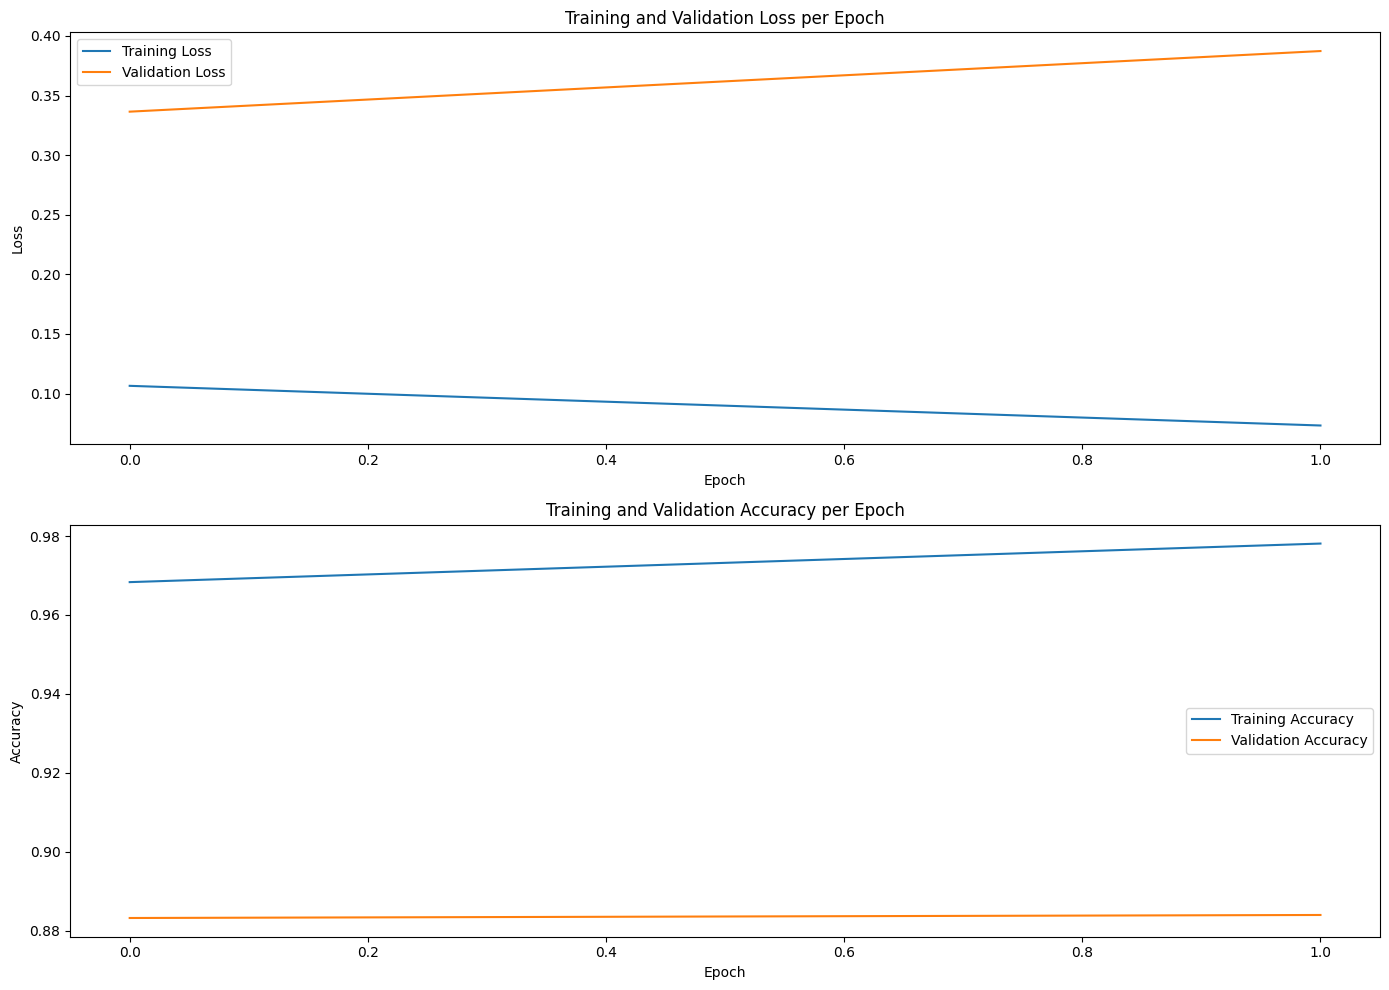

In [ ]:
# Start training
train(num_epochs, model, train_dataloader, val_dataloader, device, optimizer)

In [ ]:
dataset_name = 'XXX'
saved_model_path = './{}_bert.pth'.format(dataset_name.replace('/', '_'))

# 保存模型權重
torch.save(model.state_dict(), saved_model_path)
print(f"Model weights saved at {saved_model_path}")

Model weights saved at ./use_textrank_epoch_2_bert.pth


In [ ]:
# 加載模型架構和權重
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
# device = torch.device("cpu")
model.to(device)

# 加載訓練好的權重
# saved_model_path = './{}_bert.pth'.format(dataset_name.replace('/', '_'))
# saved_model_path = 'Amazon_Unlocked_Mobile.csv_bert.pth'
saved_model_path = 'Amazon_Unlocked_Mobile.csv_bert (1).pth'
model.load_state_dict(torch.load(saved_model_path))

# 切換模型到評估模式
# model.to(device)
model.eval()

print("Model loaded successfully and ready for inference.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-71-f8670f353d31>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

Model loaded successfully and ready for inference.


# 開始預測

In [ ]:
# 預處理文本
def preprocess_text(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    return encoding['input_ids'], encoding['attention_mask']

# 進行預測
def predict_sentiment(model, examples):
    model.eval()
    results = []
    with torch.no_grad():
        for example in examples:
            input_ids, attention_mask = preprocess_text(example)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            # 模型預測
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            # print(logits)

            # 使用 softmax 獲取每個類別的概率
            probabilities = torch.softmax(logits, dim=1)
            predicted_class = probabilities.argmax(dim=1)  # 獲取預測的類別

            results.append(predicted_class.item())  # 獲取預測類別索引

    return results

In [ ]:
def print_predicted_result(inputs, results):
    result_for_printing = [
        f'input: {inputs[i]:<30} : score: {results[i]:.1f}'
        for i in range(len(inputs))
    ]
    print(*result_for_printing, sep='\n')
    # print()

In [ ]:
# examples = [
#     'this is such an amazing movie!',
#     'The movie was great!',
#     'The movie was meh.',
#     'The movie was okish.',
#     'The movie was terrible...'
# ]

In [ ]:
# results = predict_sentiment(model, examples)
# print_predicted_result(examples, results)

In [ ]:
macrumors_data = pd.read_csv('MacRumors - MacRumors.csv')
# 轉換日期格式
date = pd.to_datetime(macrumors_data['time'], format='%b %d, %Y')
mr_after_data = macrumors_data[date > '2024-09-10']
mr_before_data = macrumors_data[(date >= '2024-08-01') & (date <= '2024-09-10')]

mr_after_contents = mr_after_data['content'].astype(str).tolist()
mr_before_contents = mr_before_data['content'].astype(str).tolist()

# 使用加載的模型進行預測
mr_predicted_results_after = predict_sentiment(model, mr_after_contents)
mr_predicted_results_before = predict_sentiment(model, mr_before_contents)

# 打印預測結果
# print('Predicted results:')
# print_predicted_result(reviews, predicted_results)

# 打包預測結果
mr_after_data['predicted_result'] = mr_predicted_results_after
mr_before_data['predicted_result'] = mr_predicted_results_before

<ipython-input-75-3ae4908fd3e1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mr_after_data['predicted_result'] = mr_predicted_results_after
<ipython-input-75-3ae4908fd3e1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mr_before_data['predicted_result'] = mr_predicted_results_before


In [ ]:
trustpilot_data = pd.read_csv('Trustpilot_commemt_data.csv')
# 轉換日期格式
date = pd.to_datetime(trustpilot_data['time'], format='%B %d, %Y')
tp_after_data = trustpilot_data[date > '2024-09-10']
tp_before_data = trustpilot_data[(date >= '2024-08-01') & (date <= '2024-09-10')]

tp_after_contents = tp_after_data['content'].astype(str).tolist()
tp_before_contents = tp_before_data['content'].astype(str).tolist()

# 使用加載的模型進行預測
tp_predicted_results_after = predict_sentiment(model, tp_after_contents)
tp_predicted_results_before = predict_sentiment(model, tp_before_contents)

# 打包預測結果
tp_after_data['predicted_result'] = tp_predicted_results_after
tp_before_data['predicted_result'] = tp_predicted_results_before

<ipython-input-76-4f982c0e2eaa>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_after_data['predicted_result'] = tp_predicted_results_after
<ipython-input-76-4f982c0e2eaa>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp_before_data['predicted_result'] = tp_predicted_results_before


In [ ]:
apir_data = pd.read_csv('APIR_commemt_data.csv')
# 轉換日期格式
date = pd.to_datetime(apir_data['time'], format='%B %d, %Y %I:%M%p')
ap_after_data = apir_data[date > '2024-09-10']
ap_before_data = apir_data[(date >= '2024-08-01') & (date <= '2024-09-10')]

ap_after_contents = ap_after_data['content'].astype(str).tolist()
ap_before_contents = ap_before_data['content'].astype(str).tolist()

# 使用加載的模型進行預測
ap_predicted_results_after = predict_sentiment(model, ap_after_contents)
ap_predicted_results_before = predict_sentiment(model, ap_before_contents)

# 打包預測結果
ap_after_data['predicted_result'] = ap_predicted_results_after
ap_before_data['predicted_result'] = ap_predicted_results_before

                                              content  \
0   \nYouTuber adapts hidden first-gen HomePod deb...   
1   \nFinally a UWB lock, a Matter ice maker, & mo...   
2   \nIn with the new, out with the old: Apple dis...   
3                  \niPhone 16 Pro impossible to buy    
4   \nProtests at Apple Stores in multiple cities ...   
5   \nApple must pay EU $14 billion over Ireland t...   
6   \nApple Fifth Avenue store gets Apple Intellig...   
7   \nNuphy Air60 V2 review: tiny & mighty mechani...   
8   \nUber Eats driver steals more than $2000 of A...   
9   \nDiving in to iPhone 16 and Apple Watch on th...   
10  \nApple releases second firmware for AirPods P...   
11  \nTrump vs. Harris: How to watch the September...   
12  \nJPMorgan could take over duties as Apple Car...   
13  \nNanoleaf CEO joins HomeKit Insider to talk l...   
14  \n'Flappy Bird' resurrection is likely a ploy ...   
15  \nA new auction has a classic Apple II cassett...   
16  \nFDA approves AirPods Pro 

<ipython-input-81-19aac210e17c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_after_data['predicted_result'] = ap_predicted_results_after
<ipython-input-81-19aac210e17c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_before_data['predicted_result'] = ap_predicted_results_before


In [ ]:
mr_after_data.to_csv('mr_after_data (predicted)_BERT_0801-0910.csv', index=False)
mr_before_data.to_csv('mr_before_data (predicted)_BERT_0801-0910.csv', index=False)

tp_after_data.to_csv('tp_after_data (predicted)_BERT_0801-0910.csv', index=False)
tp_before_data.to_csv('tp_before_data (predicted)_BERT_0801-0910.csv', index=False)

ap_after_data.to_csv('ap_after_data (predicted)_BERT_0801-0910.csv', index=False)
ap_before_data.to_csv('ap_before_data (predicted)_BERT_0801-0910.csv', index=False)

In [ ]:
# 讀取六個 CSV 文件
df1 = pd.read_csv('mr_after_data (predicted)_BERT_0801-0910.csv')
df2 = pd.read_csv('mr_before_data (predicted)_BERT_0801-0910.csv')
df3 = pd.read_csv('tp_after_data (predicted)_BERT_0801-0910.csv')
df4 = pd.read_csv('tp_before_data (predicted)_BERT_0801-0910.csv')
df5 = pd.read_csv('ap_after_data (predicted)_BERT_0801-0910.csv')
df6 = pd.read_csv('ap_before_data (predicted)_BERT_0801-0910.csv')


# 提取 Review 和 Time 列，合併 DataFrame
combined_df = pd.concat(
    [df1[['content', 'time', 'predicted_result']],
     df2[['content', 'time', 'predicted_result']],
     df3[['content', 'time', 'predicted_result']],
     df4[['content', 'time', 'predicted_result']],
     df5[['content', 'time', 'predicted_result']],
     df6[['content', 'time', 'predicted_result']]
     ], ignore_index=True)

# # 將 Time 列轉換為統一的日期時間格式
# combined_df['time'] = pd.to_datetime(combined_df['time'], errors='coerce')

# 創建新的 DataFrame 保存合併後的结果
result_df = pd.DataFrame({
    'Content': combined_df['content'],
    'Time': combined_df['time'],
    'Predicted_Result': combined_df['predicted_result']
})

# 將结果保存到新的 CSV 文件
result_df.to_csv('merged_3_sources_content_time(predicted)_BERT_0801start.csv', index=False)

print("六個文件已成功合併！")

六個文件已成功合併！


# 設定評分標準

In [ ]:
# 品牌聲譽評分設定
def calculate_score(predicted_result):
    nominator = 0
    denominator = 0

    denominator = len(predicted_result)
    positive_count = sum(1 for result in predicted_result if result == 2)
    negative_count = sum(1 for result in predicted_result if result == 0)
    nominator = positive_count - negative_count

    return nominator / denominator * 100

In [ ]:
mr_before_score = calculate_score(mr_predicted_results_before)
mr_after_score = calculate_score(mr_predicted_results_after)

tp_before_score = calculate_score(tp_predicted_results_before)
tp_after_score = calculate_score(tp_predicted_results_after)

ap_before_score = calculate_score(ap_predicted_results_before)
ap_after_score = calculate_score(ap_predicted_results_after)

after_df = combined_df[combined_df['time'] > '2024-09-10']
before_df = combined_df[(combined_df['time'] >= '2024-08-01') & (combined_df['time'] <= '2024-09-10')]
print(before_df)

# 然後對篩選後的數據計算分數
# total_after_score = calculate_score(after_df['predicted_result'])
# total_before_score = calculate_score(before_df['predicted_result'])

print(mr_before_score)
print(mr_after_score)

print(tp_before_score)
print(tp_after_score)

print(ap_before_score)
print(ap_after_score)

# print(total_before_score)
# print(total_after_score)

Empty DataFrame
Columns: [content, time, predicted_result]
Index: []
38.90090869753354
31.677218585685157
-45.09803921568628
-58.620689655172406
39.0
15.0


# 生成文字雲

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'al', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


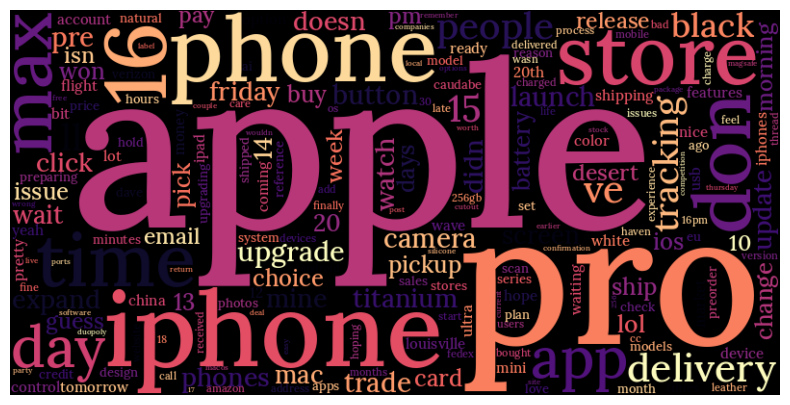

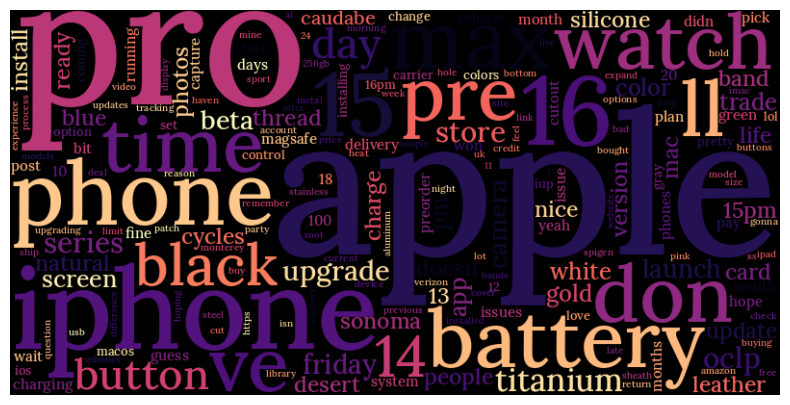

In [ ]:
# 讀取停用詞的 .txt 文件，將每行讀取為一個詞彙
with open('stopwords.txt', 'r') as f:
    custom_stopwords = [word.strip() for word in f.read().splitlines()]

total_predicted_results = pd.read_csv('merged_3_sources_content_time(predicted)_BERT_0801start.csv')
total_predicted_results['Time'] = pd.to_datetime(total_predicted_results['Time'], errors='coerce')
before_df = total_predicted_results[(total_predicted_results['Time'] >= '2024-08-01') & (total_predicted_results['Time'] <= '2024-09-10')]
after_df = total_predicted_results[total_predicted_results['Time'] > '2024-09-10']

before_df = before_df.dropna(subset=['Content'])
after_df = after_df.dropna(subset=['Content'])

# 提取關鍵詞、計算詞頻
vectorizer = CountVectorizer(stop_words=custom_stopwords)
after_vector = vectorizer.fit_transform(after_df['Content'])
word_freq = np.asarray(after_vector.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()
word_freq_dict = dict(zip(words, word_freq))

# 使用 WordCloud 生成文字雲
wordcloud = WordCloud(
    font_path='Lora-Medium-5.ttf',  # 字體路徑
    colormap='magma',               # 設置顏色映射
    width=800,                      # 設置寬度
    height=400                      # 設置高度
).generate_from_frequencies(word_freq_dict)

# 顯示文字雲
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

before_vector = vectorizer.fit_transform(before_df['Content'])
word_freq = np.asarray(before_vector.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()
word_freq_dict = dict(zip(words, word_freq))

# 使用 WordCloud 生成文字雲
wordcloud = WordCloud(
    font_path='Lora-Medium-5.ttf',  # 字體路徑
    colormap='magma',               # 設置顏色映射
    width=800,                      # 設置寬度
    height=400                      # 設置高度
).generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#視覺化
待確認哪些結果需要「互動式呈現」

1. 輸入評論，就能看到該評論的情感分析結果

2. 選擇某品牌 & 某個時間段，就能看到該時間段的品牌聲譽評分變化（折線圖）

In [ ]:
# # 設置 Gradio 接口
# iface = gr.Interface(
#     fn=sentiment_score,
#     inputs=gr.Textbox(label="輸入評論"),
#     outputs=gr.Label(label="情感分析結果")
# )

# iface2 = gr.Interface(
#     fn=calculate_reputation_score,
#     inputs=[gr.Number(label="正面評論數量"),
#             gr.Number(label="負面評論數量"),
#             gr.Number(label="中立評論數量")],
#     outputs=gr.Number(label="品牌聲譽評分")
# )

# # 運行 Gradio 接口
# iface.launch()
# iface2.launch()

# 分開處理每月的評論

In [ ]:
monthly_data = pd.read_csv('Extracted_Review_Data.csv')

NameError: name 'pd' is not defined

In [ ]:
unique_months = np.sort(monthly_data['Month'].unique())
unique_years = np.sort(monthly_data['Year'].unique())

In [ ]:
def calculate_score(predicted_result):
    nominator = 0
    denominator = len(predicted_result)

    positive_count = sum(1 for result in predicted_result if result == 2)
    negative_count = sum(1 for result in predicted_result if result == 0)
    nominator = positive_count - negative_count

    return nominator / denominator * 100 if denominator > 0 else 0

In [ ]:
def preprocess_text_batch(texts, tokenizer, max_length=128):
    encodings = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    return encodings['input_ids'], encodings['attention_mask']

In [ ]:
def predict_sentiment(model, examples, tokenizer, batch_size=16):
    model.to(device)
    model.eval()
    results = []

    # 將文本分批處理
    for i in range(0, len(examples), batch_size):
        batch_examples = examples[i:i + batch_size]

        # 預處理文本批次
        input_ids, attention_mask = preprocess_text_batch(batch_examples, tokenizer)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        with torch.no_grad():
            # 模型預測
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # 使用 softmax 獲取每個類別的概率
            probabilities = torch.softmax(logits, dim=1)
            predicted_classes = probabilities.argmax(dim=1)  # 獲取預測的類別

            # 將結果轉換為列表，並加入結果
            results.extend(predicted_classes.cpu().numpy())

    return results

In [ ]:
def get_share_of_mind(unique_years, unique_months, monthly_data, model, tokenizer):
    data = {}
    for unique_year in unique_years:
        data[unique_year] = {}
        data[unique_year]['month'] = []
        data[unique_year]['share_of_mind'] = []
        for unique_month in unique_months:
            if unique_year == 2024 and unique_month > 9:
                break
            else:
                month_data = monthly_data[(monthly_data['year'] == unique_year) & (monthly_data['month'] == unique_month)]
                if month_data.empty:
                    continue
                data[unique_year]['month'].append(unique_month)
                contents = month_data['Merged_Review'].astype(str).tolist()
                predicted_results = predict_sentiment(model, contents, tokenizer)
                score = calculate_score(predicted_results)
                data[unique_year]['share_of_mind'].append(score)
                print(f"{unique_year}-{unique_month}: {score}")
    return data


In [ ]:
data = get_share_of_mind(unique_years, unique_months, monthly_data, model, tokenizer)

2015-4: 33.161108501643966
2015-5: 28.653745416448402
2015-6: 34.73684210526316
2015-7: 31.161971830985912
2015-8: 30.81967213114754
2015-9: 31.886792452830186
2015-10: 33.33333333333333
2015-11: 32.450331125827816
2015-12: 26.25
2016-1: 24.528301886792452
2016-2: 33.63636363636363
2016-3: 32.8125
2016-4: 31.654676258992804
2016-5: 37.2093023255814
2016-6: 42.857142857142854
2016-7: 11.428571428571429
2016-8: 49.23076923076923
2016-9: 39.89637305699482
2016-10: 39.39393939393939
2016-11: 36.0
2016-12: 44.66019417475729
2017-1: 38.55421686746988
2017-2: 48.18181818181818
2017-3: 51.515151515151516
2017-4: 46.98795180722892
2017-5: 48.214285714285715
2017-6: 44.44444444444444
2017-7: 36.84210526315789
2017-8: 33.33333333333333
2017-9: 31.137724550898206
2017-10: 34.25925925925926
2017-11: 47.12643678160919
2017-12: 44.303797468354425
2018-1: 27.500000000000004
2018-2: 52.083333333333336
2018-3: 49.18032786885246
2018-4: 50.0
2018-5: 8.333333333333332
2018-6: 54.166666666666664
2018-7: 54

In [ ]:
df = pd.DataFrame(data)
df.to_csv('results.csv', index=False)